##   Sommaire
1. Contexte
2. Chargement des modules et lecture du dataset
3. Data Preparation
5. Data Exploration
4. Modélisation prédictive:

     A.
     B.
     C. Modèle XGBoost
     C.
     
5. Implémentation du Modèle prédictif
6. Conclusion

## Contexte

## Chargement des modules et lecture du dataset

In [1]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)#Afficher toutes les colonnes

import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore") #ignore annoying warning (from sklearn and seaborn)

import math
from scipy.stats import kstest
from scipy.stats import zscore
import statsmodels.formula.api as sm
from sklearn.preprocessing import scale

%matplotlib inline

In [2]:
# plot distributions
def plot_cums(dist1, dist2):
    # sort the first data sample:
    data_sorted = np.sort(dist1)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(dist1)) / (len(dist1) - 1)

    # Now plot as line and scatter plot.
    plt.plot(data_sorted, p)
    plt.scatter(data_sorted, p, color='red')

    # sort the seond data sample:
    data_sorted = np.sort(dist2)

    # And the second plot
    plt.plot(data_sorted, p, color='yellow')
    plt.scatter(data_sorted, p, color='green')

# Create Box Plot


def plotBox(column, depVar, df, x=9, rotation=0):
    fig = plt.figure(figsize=(x, 9))
    ax = fig.gca()
    df.loc[:, [depVar, column]].boxplot(by=column, ax=ax)
    ax.set_title('Box plot of ' + depVar + ' vs. ' + column)
    ax.set_ylabel(depVar)
    ax.tick_params(axis='x', labelrotation=rotation)

# Bootstrap


def bootStrap(df, column, choice1, choice2, depVar, n_replicas=1000):
    a = df[df[column] == choice1]
    b = df[df[column] == choice2]

    a_bootstrap_means = pd.Series([
        a.sample(frac=1, replace=True)[depVar].mean()
        for i in range(n_replicas)])

    b_bootstrap_means = pd.Series([
        b.sample(frac=1, replace=True)[depVar].mean()
        for i in range(n_replicas)])

    plot_dists(a=a_bootstrap_means, b=b_bootstrap_means,
               nbins=80, a_label=choice1, b_label=choice2, depVar=depVar)


# Bootstrap Mean Diffs
def bootStrapDiffs(df, column, choice1, choice2, depVar, n_replicas=1000):
    diffs = []
    for i in range(n_replicas):
        sample = df.sample(frac=1.0, replace=True)
        a_sample_mean = sample[sample[column] == choice1][depVar].mean()
        b_sample_mean = sample[sample[column] == choice2][depVar].mean()
        diffs.append(a_sample_mean - b_sample_mean)
    diffs = pd.Series(diffs)

    plot_hist(x=diffs, a=choice1, b=choice2, depVar=depVar)

# Function used by Bootstrap function
# plots Distributions with 95% CI.


def plot_dists(a, b, nbins, a_label='pop_A', b_label='pop_B', depVar='variable', p=5):
    # Create a single sequence of bins to be shared across both
    # distribution plots for visualization consistency.
    combined = pd.concat([a, b])
    breaks = np.linspace(
        combined.min(),
        combined.max(),
        num=nbins+1)

    plt.subplot(2, 1, 1)
    plt.hist(a, bins=breaks, alpha=.5)
    plt.axvline(a.mean(), linewidth=4)
    plt.axvline(np.percentile(a, p/2.), color='red', linewidth=3)
    plt.axvline(np.percentile(a, 100-p/2.), color='red', linewidth=3)
    plt.title(a_label)
    plt.xlabel(depVar)

    plt.subplot(2, 1, 2)
    plt.hist(b, bins=breaks, alpha=.5)
    plt.axvline(b.mean(), linewidth=4)
    plt.axvline(np.percentile(b, p/2.), color='red', linewidth=3)
    plt.axvline(np.percentile(b, 100-p/2.), color='red', linewidth=3)
    plt.title(b_label)
    plt.xlabel(depVar)

    plt.tight_layout()

# Function used by Bootstrap  diff function
# plots histogram with 95% CI.


def plot_hist(x, a, b, depVar='variable', p=5):
    plt.hist(x, alpha=.5)
    plt.axvline(x.mean(), linewidth=4)
    plt.axvline(np.percentile(x, p/2.), color='red', linewidth=3)
    plt.axvline(np.percentile(x, 100-p/2.), color='red', linewidth=3)
    plt.title(str(a) + " - " + str(b))
    plt.xlabel(depVar + " Mean Differences")

In [3]:
# change the default directory
import os
os.chdir(r"C:\Users\Fitec\Desktop\CBDATA\house_sales_kcountry\housesalesprediction")

In [4]:
#importer le dataset
dtrain = pd.read_table("kc_house_data.csv",sep=",",header=0)

In [5]:
#Afficher les 5ère colonnes
print(dtrain.head())
#Afficher les 5 dernières colonnes
print(dtrain.tail())

           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
0      5650     1.0           0     0          3      7        1180   
1      7242     2.0           0     0          3      7        2170   
2     10000     1.0           0     0          3      6         770   
3      5000     1.0           0     0          5      7        1050   
4      8080     1.0           0     0          3      8        1680   

   sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0              0      1955       

In [6]:
print(dtrain.shape)
print(dtrain.dtypes) 

(21613, 21)
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object


## Data Preparation

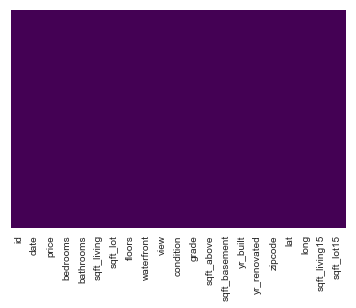

In [7]:
# Recherchons les valeurs nulles 
sns.heatmap(dtrain.isnull(),yticklabels=False,cbar=False,cmap='viridis')
#print(dtrain.isnull().any())

Nous observons sur ce graphe qu'il y a pas de valeurs nulles dans notre dataFrame dtrain

In [8]:
#dtrain.describe()

In [9]:
dtrain.nunique()

id               21436
date               372
price             4028
bedrooms            13
bathrooms           30
sqft_living       1038
sqft_lot          9782
floors               6
waterfront           2
view                 5
condition            5
grade               12
sqft_above         946
sqft_basement      306
yr_built           116
yr_renovated        70
zipcode             70
lat               5034
long               752
sqft_living15      777
sqft_lot15        8689
dtype: int64

Définissons notre date sur un date type et créons une colonne mois et année. Cela nous aidera à avoir une meilleure idée des données dont nous disposons.

In [10]:
dtrain['date'] = pd.to_datetime(dtrain['date']) #Convertir les dates en format Date
dtrain['month'] = pd.DatetimeIndex(dtrain.loc[:,'date']).month #Créer une colonne Mois
dtrain['year'] = pd.DatetimeIndex(dtrain.loc[:,'date']).year #Créer une colonne Année

In [11]:
#Afficher les valeurs uniues de nos features
print('Dates \n', dtrain['date'].nunique())
print('Years \n', dtrain['year'].unique())
print('Months \n', dtrain['month'].unique())
print('Bedrooms \n', dtrain['bedrooms'].unique())
print('Bathrooms \n', dtrain['bathrooms'].unique())
print('Floors \n', dtrain['floors'].unique())
print('Waterfront \n', dtrain['waterfront'].unique())
print('Views \n', dtrain['view'].unique())
print('Condition \n', dtrain['condition'].unique())
print('Grades \n', dtrain['grade'].unique())
print('Years Built \n', dtrain['yr_built'].unique())
print('Years Renovated \n', dtrain['yr_renovated'].unique())
print('Zip Codes \n', dtrain['zipcode'].unique())
print('Latitude \n', dtrain['lat'].nunique())
print('Longitude \n', dtrain['long'].nunique())
print('Square Foot Living \n', dtrain['sqft_living'].nunique())
print('Square Foot Lot \n', dtrain['sqft_lot'].nunique())
print('Square Foot Living 15\n', dtrain['sqft_living15'].nunique())
print('Square Foot Lot 15\n', dtrain['sqft_lot15'].nunique())
print('Square Foot Above \n', dtrain['sqft_above'].nunique())
print('Square Foot Basement \n', dtrain['sqft_basement'].nunique())

Dates 
 372
Years 
 [2014 2015]
Months 
 [10 12  2  5  6  1  4  3  7  8 11  9]
Bedrooms 
 [ 3  2  4  5  1  6  7  0  8  9 11 10 33]
Bathrooms 
 [1.   2.25 3.   2.   4.5  1.5  2.5  1.75 2.75 3.25 4.   3.5  0.75 4.75
 5.   4.25 3.75 0.   1.25 5.25 6.   0.5  5.5  6.75 5.75 8.   7.5  7.75
 6.25 6.5 ]
Floors 
 [1.  2.  1.5 3.  2.5 3.5]
Waterfront 
 [0 1]
Views 
 [0 3 4 2 1]
Condition 
 [3 5 4 1 2]
Grades 
 [ 7  6  8 11  9  5 10 12  4  3 13  1]
Years Built 
 [1955 1951 1933 1965 1987 2001 1995 1963 1960 2003 1942 1927 1977 1900
 1979 1994 1916 1921 1969 1947 1968 1985 1941 1915 1909 1948 2005 1929
 1981 1930 1904 1996 2000 1984 2014 1922 1959 1966 1953 1950 2008 1991
 1954 1973 1925 1989 1972 1986 1956 2002 1992 1964 1952 1961 2006 1988
 1962 1939 1946 1967 1975 1980 1910 1983 1978 1905 1971 2010 1945 1924
 1990 1914 1926 2004 1923 2007 1976 1949 1999 1901 1993 1920 1997 1943
 1957 1940 1918 1928 1974 1911 1936 1937 1982 1908 1931 1998 1913 2013
 1907 1958 2012 1912 2011 1917 1932 1944 1902 2

Nous pouvons constater que nous avons environ 1 année d'entrées, soit 372 jours, ce sont des données globales couvrant la période 2014-2015, avec une entrée pour chaque mois. Nous ne disposons pas d'un échantillon couvrant une période suffisamment longue pour effectuer une analyse de série chronologique utile. Nous pouvons voir que nous avons des maisons construites de 1900 à 2015 et des maisons rénovées à non rénovés entre 1934 à 2015. La variable waterfront est binaire, nous devrions la convertir pour notre exploration. Les feautures View, Condition et Grade doivent être convertis ausii. Il semble y avoir des maisons de plus de 10 chambres.

In [12]:
print(dtrain.loc[dtrain['bedrooms'] >10,:] )

               id       date     price  bedrooms  bathrooms  sqft_living  \
8757   1773100755 2014-08-21  520000.0        11       3.00         3000   
15870  2402100895 2014-06-25  640000.0        33       1.75         1620   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
8757       4960     2.0           0     0          3      7        2400   
15870      6000     1.0           0     0          5      7        1040   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
8757             600      1918          1999    98106  47.5560 -122.363   
15870            580      1947             0    98103  47.6878 -122.331   

       sqft_living15  sqft_lot15  month  year  
8757            1420        4960      8  2014  
15870           1330        4700      6  2014  


La plupart de nos données ont l'air propres et ont du sens, à l'exception d'une entrée avec 33 chambres et 1.75 salles de bain d'une surface habitable de 1620 pieds carrés. C'est probablement une faute de frappe et devrait probablement être que 3 chambres à coucher; cependant, nous ne sommes pas sûrs à 100% de ce que le nombre correct devrait être alors exécutant cette ligne




In [13]:
#Supprimer les 30 colonnes de Bedrooms
Asupprimer = dtrain.loc[dtrain['bedrooms'] == 33,'bedrooms'].index.tolist()
dtrain.drop(Asupprimer, axis = 0, inplace = True)
dtrain.drop('id', axis = 1, inplace = True)

Créons maintenant de nouvelles variabes binaires qui pourraient nous être utiles. Créons une variable pour voir si une maison a été rénovée ou non. Une autre pour voir si c'est une nouvelle rénovation, ce qui sera une rénovation supérieure à l'année moyenne de rénovation. Une variable pour savoir si c'est une nouvelle construction, qui sera n'importe quelle maison construite sur l'année moyenne de construction. Et une autre variable pour savoir si la maison a un sous-sol ou non. Nous allons également créer une colonne pour convertir waterfront

Commençons par trouver la moyenne de l'année de construction et de rénovation

In [14]:
print('Year Built Min: ', dtrain['yr_built'].min()) #print min year built
print('Year Built Max: ', dtrain['yr_built'].max()) #print max year built
print('Year Built Mean: ', np.mean(dtrain['yr_built'])) #print mean year built
print('Year Renovated Min: ', dtrain.loc[dtrain['yr_renovated'] > 0,'yr_renovated'].min()) #min year renovated excluding not reno
print('Year Renovated Max: ', dtrain['yr_renovated'].max()) #max year renovated excluding not reno
print('Year Renovated Mean: ', (np.mean(dtrain.loc[dtrain['yr_renovated'] > 0,'yr_renovated']))) #mean year renovated excluding not reno

Year Built Min:  1900
Year Built Max:  2015
Year Built Mean:  1971.0062465297058
Year Renovated Min:  1934
Year Renovated Max:  2015
Year Renovated Mean:  1995.8271334792123


In [15]:
#Créons de nouvelles variables
dtrain.loc[dtrain.loc[:,'yr_renovated'] > 0 , "renovated"] = 1
dtrain.loc[dtrain.loc[:,'yr_renovated'] == 0, "renovated"] = 0

dtrain.loc[dtrain.loc[:,'yr_renovated'] > 1995 , "newReno"] = 1
dtrain.loc[dtrain.loc[:,'yr_renovated'] < 1996, "newReno"] = 0

dtrain.loc[dtrain.loc[:,'yr_built'] > 1970 , "newBuild"] = 1
dtrain.loc[dtrain.loc[:,'yr_built'] < 1971, "newBuild"] = 0

dtrain.loc[dtrain.loc[:,'sqft_basement'] > 0 , "hasBsmnt"] = 1
dtrain.loc[dtrain.loc[:,'sqft_basement'] == 0, "hasBsmnt"] = 0

dtrain.loc[dtrain.loc[:,'waterfront'] > 0 , "wfName"] = 'Wtrfrnt'
dtrain.loc[dtrain.loc[:,'waterfront'] == 0, "wfName"] = 'noWtrFrnt'

In [16]:
#Convertir les nouvelles variables en int
def setTypes(dataF, i, varType):
     dataF.loc[:,i] = dataF.loc[:,i].astype(varType)
     
setTypes(dtrain,'renovated', 'int64')
setTypes(dtrain,'newReno', 'int64')
setTypes(dtrain,'newBuild', 'int64')
setTypes(dtrain,'hasBsmnt', 'int64')

Créons maintenant une colonne log price et une autre colonne z-scaled de nos colonnes de price et log price.

In [17]:
def getLog(price):
     return math.log(price)

In [18]:
dtrain['log_price'] = dtrain['price'].apply(getLog)

In [19]:
#Standardize our price and log price and save to dfs
dtrain['priceS'] = scale(dtrain.loc[:,'price'])
dtrain['logPS']= scale(dtrain.loc[:,'log_price'])

In [20]:
#Decode columns
dtrain.loc[dtrain['view'] == 0, 'viewName'] = 'view0'
dtrain.loc[dtrain['view'] == 1, 'viewName'] = 'view1'
dtrain.loc[dtrain['view'] == 2, 'viewName'] = 'view2'
dtrain.loc[dtrain['view'] == 3, 'viewName'] = 'view3'
dtrain.loc[dtrain['view'] == 4, 'viewName'] = 'view4'

dtrain.loc[dtrain['condition'] == 1, 'condName'] = 'cond1'
dtrain.loc[dtrain['condition'] == 2, 'condName'] = 'cond2'
dtrain.loc[dtrain['condition'] == 3, 'condName'] = 'cond3'
dtrain.loc[dtrain['condition'] == 4, 'condName'] = 'cond4'
dtrain.loc[dtrain['condition'] == 5, 'condName'] = 'cond5'

dtrain.loc[dtrain['grade'] == 1, 'gradeName'] = 'grade1'
dtrain.loc[dtrain['grade'] == 3, 'gradeName'] = 'grade3'
dtrain.loc[dtrain['grade'] == 4, 'gradeName'] = 'grade4'
dtrain.loc[dtrain['grade'] == 5, 'gradeName'] = 'grade5'
dtrain.loc[dtrain['grade'] == 6, 'gradeName'] = 'grade6'
dtrain.loc[dtrain['grade'] == 7, 'gradeName'] = 'grade7'
dtrain.loc[dtrain['grade'] == 8, 'gradeName'] = 'grade8'
dtrain.loc[dtrain['grade'] == 9, 'gradeName'] = 'grade9'
dtrain.loc[dtrain['grade'] == 10, 'gradeName'] = 'grade10'
dtrain.loc[dtrain['grade'] == 11, 'gradeName'] = 'grade11'
dtrain.loc[dtrain['grade'] == 12, 'gradeName'] = 'grade12'
dtrain.loc[dtrain['grade'] == 13, 'gradeName'] = 'grade13'

In [21]:
#Get Dummies 
dummies = pd.get_dummies(dtrain.loc[:, 'viewName'], drop_first = True)
dtrain[list(dummies.columns)] = dummies
dummies = pd.get_dummies(dtrain.loc[:, 'condName'], drop_first = True)
dtrain[list(dummies.columns)] = dummies
dummies = pd.get_dummies(dtrain.loc[:, 'gradeName'], drop_first = True)
dtrain[list(dummies.columns)] = dummies

Réinitialisons Index  et examinons maintenant notre dataFrame.

In [22]:
dtrain.reset_index(drop = True, inplace = True)

In [23]:
print(dtrain.head())

        date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0 2014-10-13  221900.0         3       1.00         1180      5650     1.0   
1 2014-12-09  538000.0         3       2.25         2570      7242     2.0   
2 2015-02-25  180000.0         2       1.00          770     10000     1.0   
3 2014-12-09  604000.0         4       3.00         1960      5000     1.0   
4 2015-02-18  510000.0         3       2.00         1680      8080     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        1180              0      1955   
1           0     0          3      7        2170            400      1951   
2           0     0          3      6         770              0      1933   
3           0     0          5      7        1050            910      1965   
4           0     0          3      8        1680              0      1987   

   yr_renovated  zipcode      lat     long  sqft_living15  sqf

In [24]:
print(dtrain.shape) 
print(dtrain.dtypes) 

(21612, 52)
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
month                     int64
year                      int64
renovated                 int64
newReno                   int64
newBuild                  int64
hasBsmnt                  int64
wfName                   object
log_price               float64
priceS                  float64
logPS                   float64
viewName                 obj

Nos données semblent être préparées. Jetons un coup d'œil et décidons si nous utiliserons notre prix ou le prix du log comme variable dépendante.

## Data Exploration

Commençons par tracer notre distribution de price et log price, puis testons KS par rapport à une distribution normale.

In [25]:
#conduct KS test
def ks_test(data, dist = 'norm'):
    ks_stat, pvalue = kstest(data, dist) 
    print('KS-statistic = ' + str(ks_stat)) 
    print('P-value = ' + str(pvalue)) 

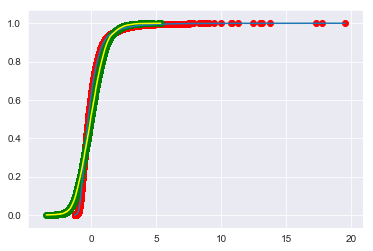

In [26]:
#Plot our standardize price columns
plot_cums(dtrain['priceS'], dtrain['logPS'])  

In [27]:
ks_test(dtrain['priceS'])  

KS-statistic = 0.14575641161896524
P-value = 0.0


In [28]:
ks_test(dtrain['logPS'])  

KS-statistic = 0.025999745066504487
P-value = 4.087372681309172e-13


Aucune distribution n'est normale; Cependant, le log price scaled a une valeur K plus petite et une valeur p plus grande, ce qui signifie qu'il est plus normal.

Regardons l'histogramme de log price et price.

Text(0.5,1,'Price Histogram')

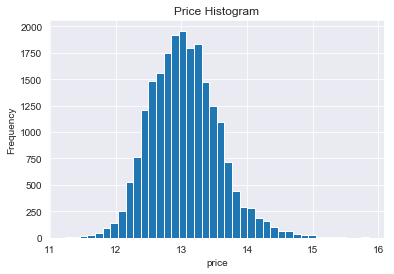

In [29]:
dtrain['log_price'].plot.hist(bins = 40)
plt.xlabel('price')
plt.title('Price Histogram')

Text(0.5,1,'Price Histogram')

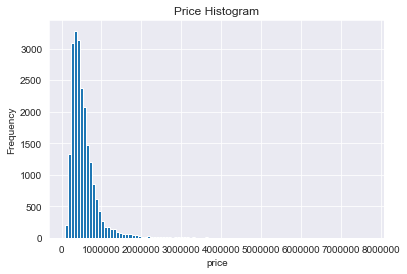

In [30]:
dtrain['price'].plot.hist(bins = 100)
plt.xlabel('price')
plt.title('Price Histogram')

Nous pouvons voir que les prix des maisons sont assez normalement distribués lorsque l’on examine l’histogramme des prix des grumes. Notre histogramme des prix nous montre que la plupart de nos maisons se situent autour de 500 000 dollars et que la majorité des maisons se situe dans une fourchette allant de 0 à 1 000 000 dollars, certaines maisons s’établissant à 8 millions de dollars. Nous utiliserons le log de prix proportionné, car il est plus normal et donnera probablement de meilleurs résultats.

Notre log échelle de prix varie de -3,46 à 5,33. Cela se traduit par une fourchette de prix allant de 75 000 à 7,7 millions de dollars. Un prix logarithmique mis à l'échelle de 0 est égal à 445 000 $.

Choisissons des colonnes qui, à notre avis, peuvent avoir un effet sur le prix et créons un graphe par paires.

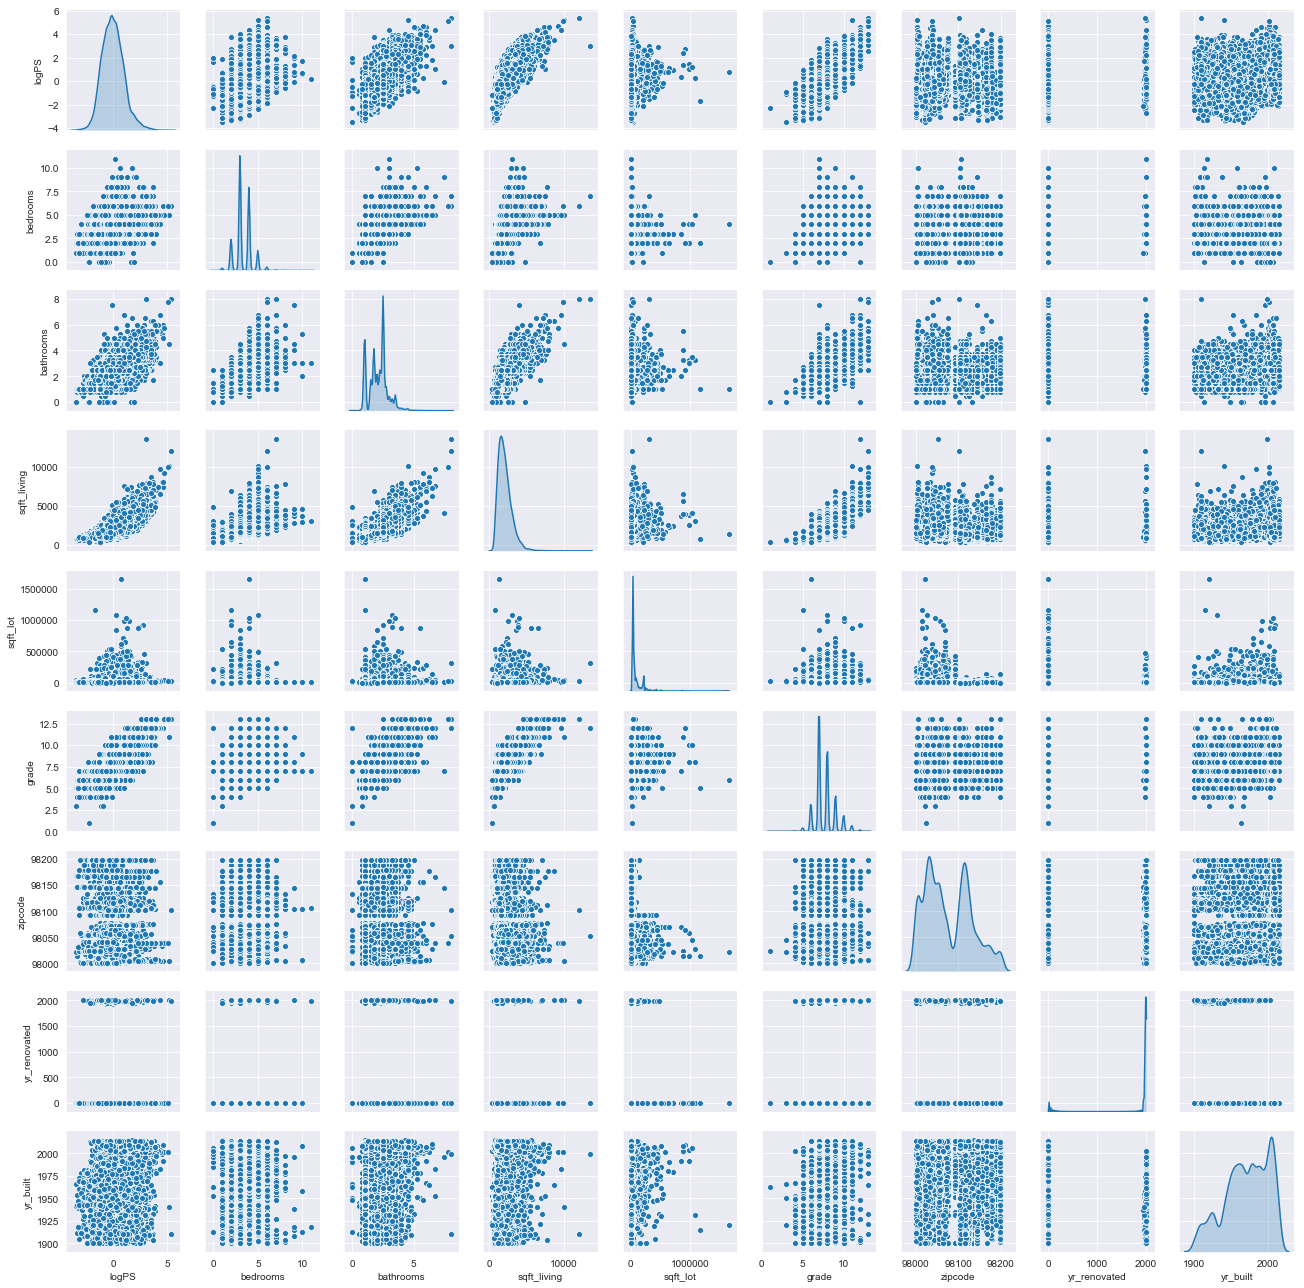

In [31]:
#Pairplot of given columns
num_cols = ["logPS", "bedrooms", "bathrooms", "sqft_living", "sqft_lot",  "grade", "zipcode", "yr_renovated", "yr_built"] 
sns.pairplot(dtrain.loc[:, num_cols], 
             diag_kind="kde", 
             size=2)

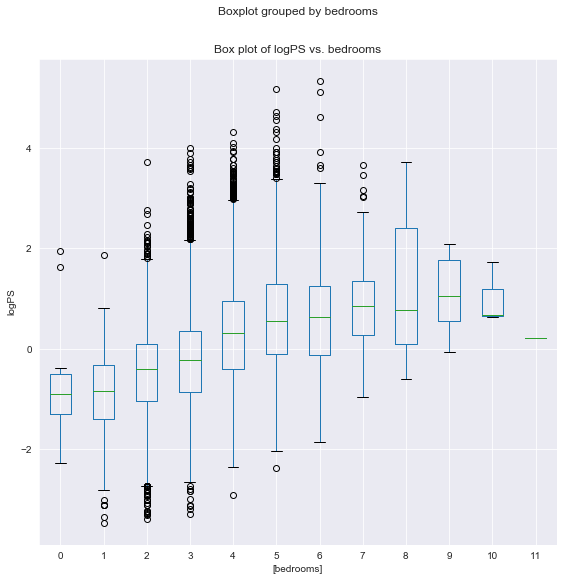

In [32]:
plotBox('bedrooms', 'logPS', dtrain)

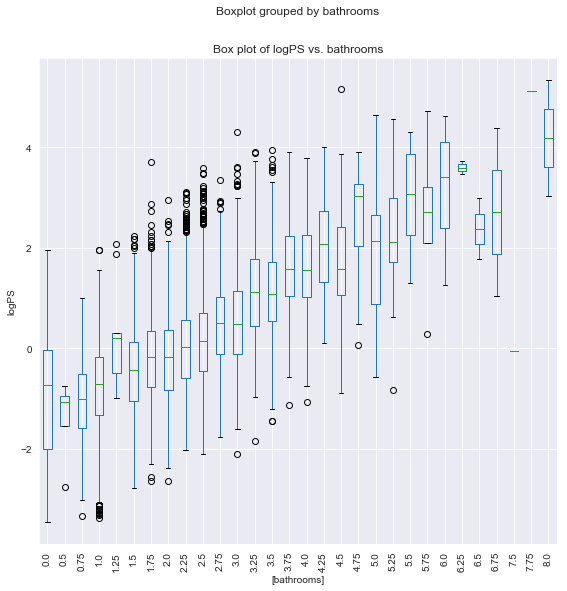

In [33]:
plotBox('bathrooms', 'logPS', dtrain, rotation = 90)

Text(0.5,0,'Square Foot Living')

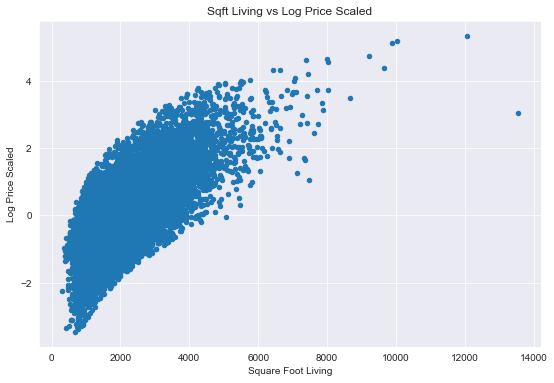

In [34]:
ax = plt.figure(figsize=(9, 6)).gca() 
dtrain.plot.scatter(x = 'sqft_living', y = 'logPS', ax = ax)
ax.set_title('Sqft Living vs Log Price Scaled') 
ax.set_ylabel('Log Price Scaled')
ax.set_xlabel('Square Foot Living')

Text(0.5,1,'SQFT Living vs House Price with Hue by Waterfront\n')

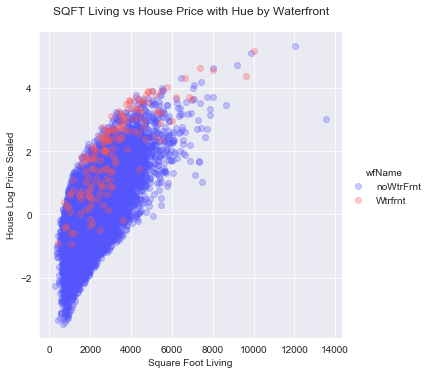

In [35]:
sns.lmplot(x = 'sqft_living', y = 'logPS', 
           data = dtrain, 
           hue = "wfName", 
           palette="seismic", 
           scatter_kws={'alpha':0.3, 
                        },
           fit_reg = False)
plt.xlabel('Square Foot Living')
plt.ylabel('House Log Price Scaled')
plt.title('SQFT Living vs House Price with Hue by Waterfront\n')

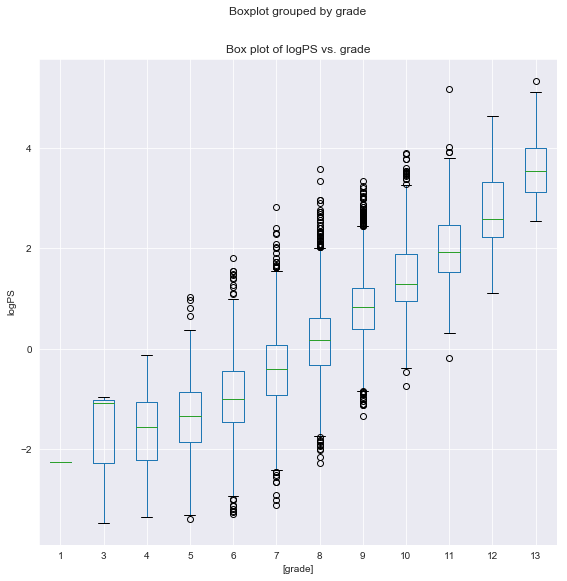

In [36]:
plotBox('grade', 'logPS', dtrain)

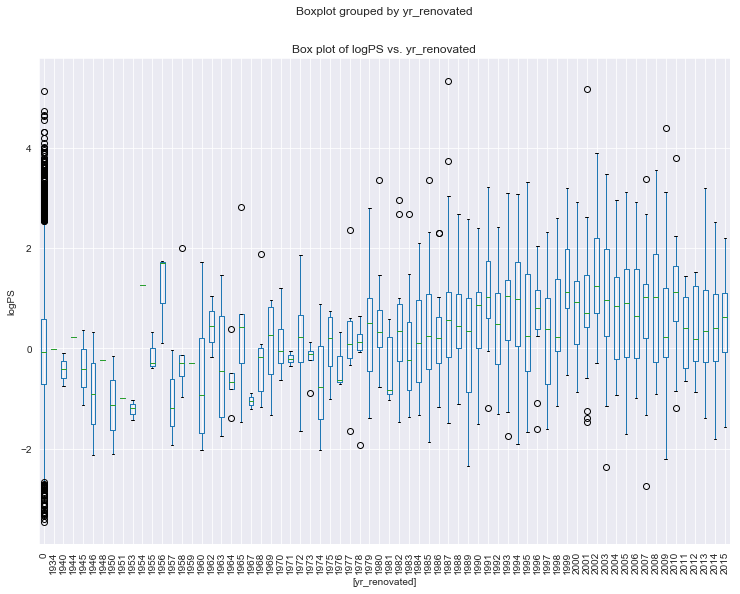

In [37]:
plotBox('yr_renovated', 'logPS', dtrain, x = 12, rotation = 90)

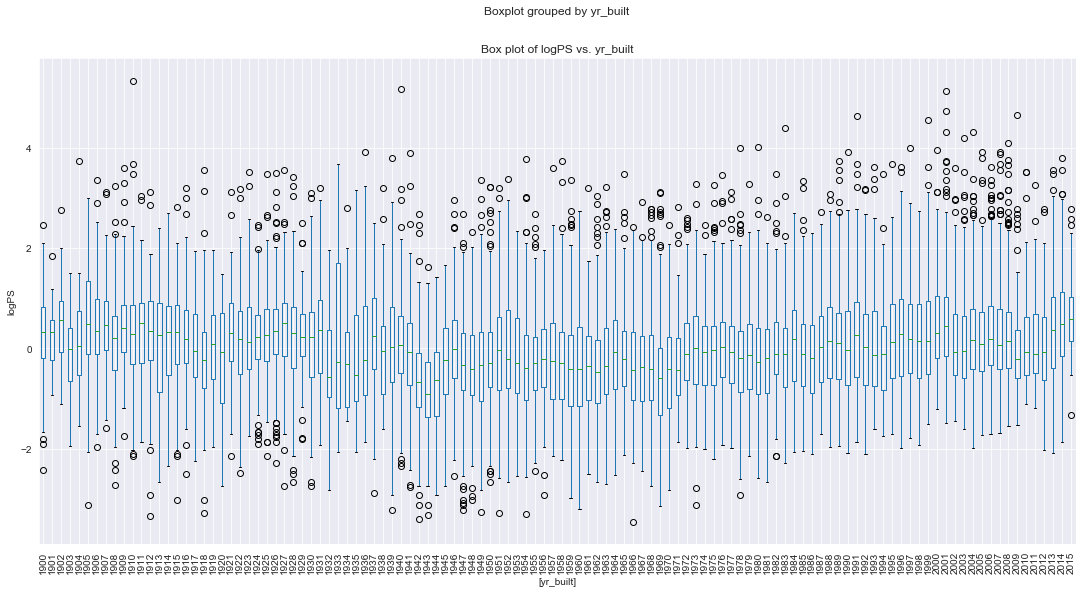

In [38]:
plotBox('yr_built', 'logPS', dtrain, x = 18, rotation = 90)

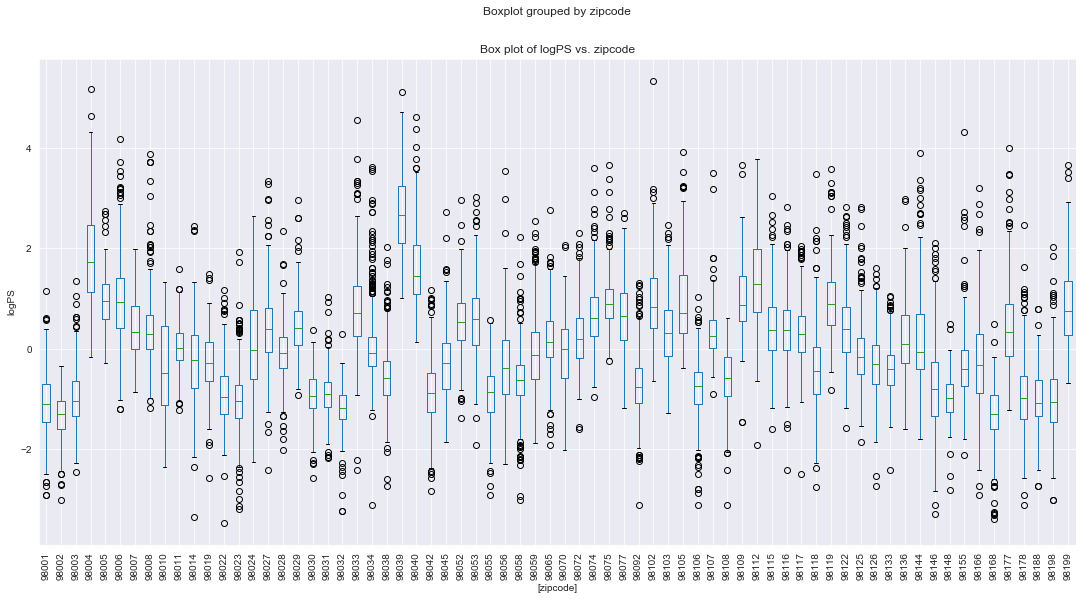

In [39]:
plotBox('zipcode', 'logPS', dtrain, x = 18, rotation = 90)

In [40]:
#Convertir zipcode
dtrain['zipTop'] = 'otherZip'
dtrain.loc[dtrain['zipcode'] == 98039, 'zipTop'] = 'zip1'
dtrain.loc[dtrain['zipcode'] == 98004, 'zipTop'] = 'zip2'
dtrain.loc[dtrain['zipcode'] == 98040, 'zipTop'] = 'zip3'
dtrain.loc[dtrain['zipcode'] == 98112, 'zipTop'] = 'zip4'

#encode zipTop
dummies = pd.get_dummies(dtrain.loc[:, 'zipTop'], drop_first = True)
dtrain[list(dummies.columns)] = dummies

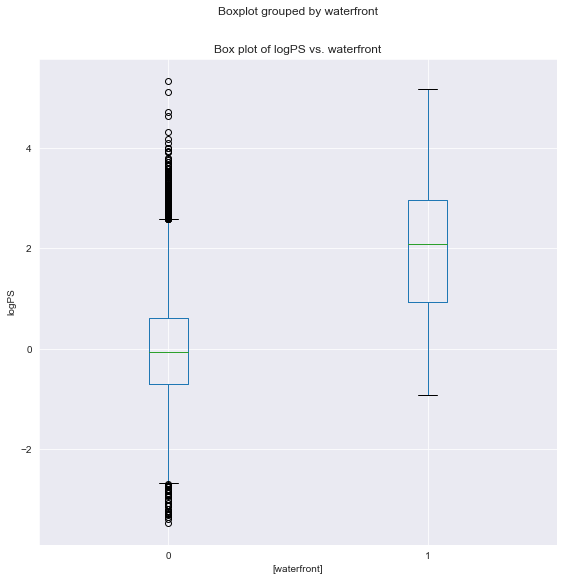

In [41]:
plotBox('waterfront', 'logPS', dtrain)

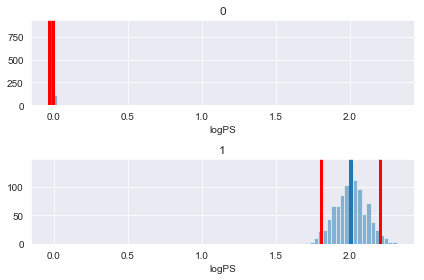

In [42]:
bootStrap(dtrain, 'waterfront', 0, 1, 'logPS')

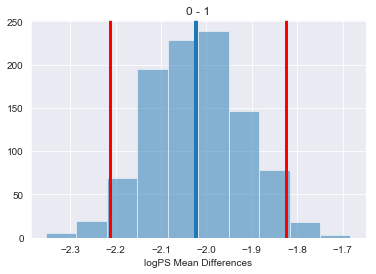

In [43]:
bootStrapDiffs(dtrain, 'waterfront', 0, 1, 'logPS')

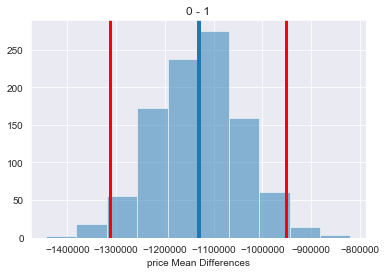

In [44]:
bootStrapDiffs(dtrain, 'waterfront', 0, 1, 'price')

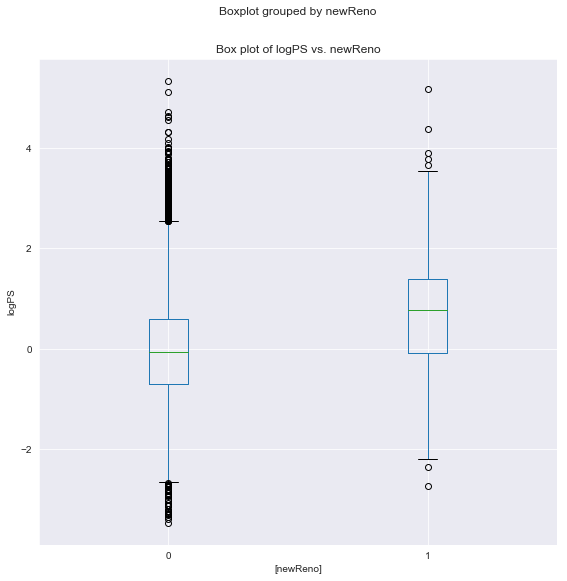

In [45]:
plotBox('newReno', 'logPS', dtrain)

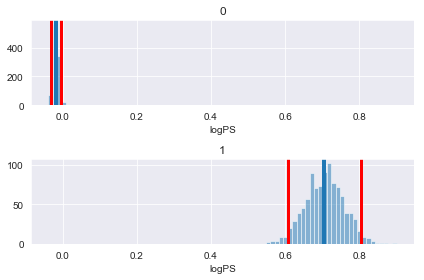

In [46]:
bootStrap(dtrain, 'newReno', 0, 1, 'logPS')

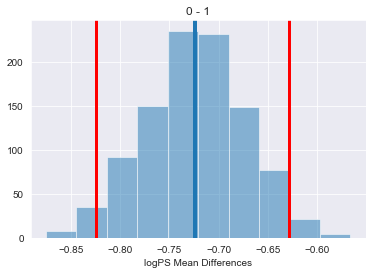

In [47]:
bootStrapDiffs(dtrain, 'newReno', 0, 1, 'logPS')

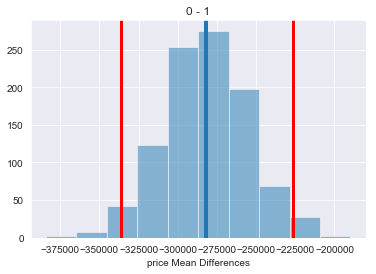

In [48]:
bootStrapDiffs(dtrain, 'newReno', 0, 1, 'price')

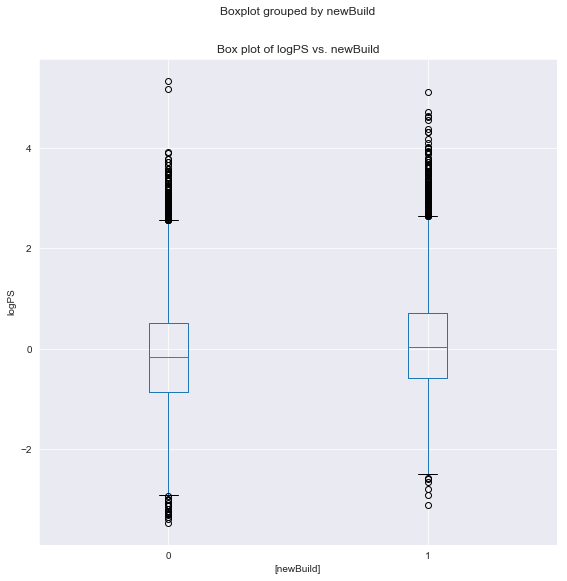

In [49]:
plotBox('newBuild', 'logPS', dtrain)

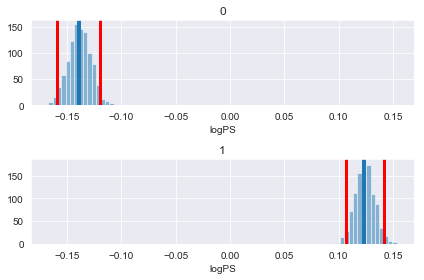

In [50]:
bootStrap(dtrain, 'newBuild', 0, 1, 'logPS')

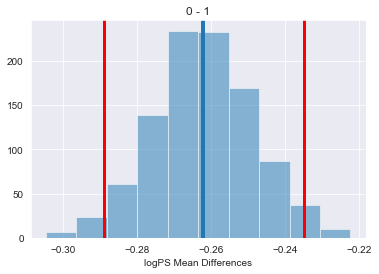

In [51]:
bootStrapDiffs(dtrain, 'newBuild', 0, 1, 'logPS')

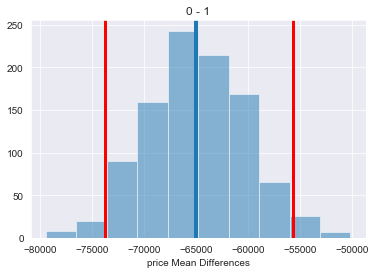

In [52]:
bootStrapDiffs(dtrain, 'newBuild', 0, 1, 'price')

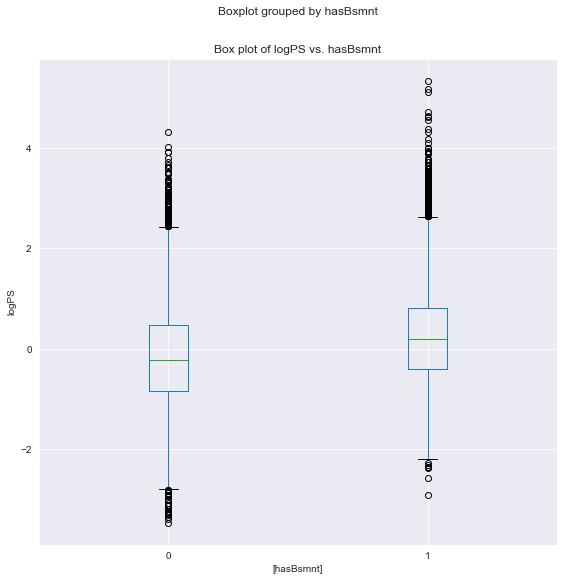

In [53]:
plotBox('hasBsmnt', 'logPS', dtrain)

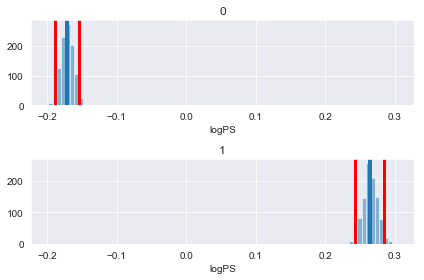

In [54]:
bootStrap(dtrain, 'hasBsmnt', 0, 1, 'logPS')

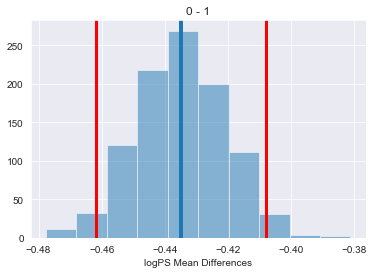

In [55]:
bootStrapDiffs(dtrain, 'hasBsmnt', 0, 1, 'logPS')

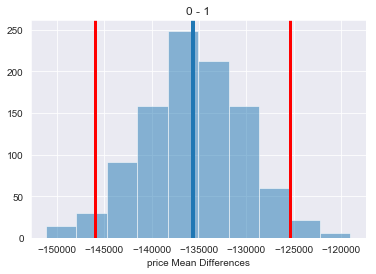

In [56]:
bootStrapDiffs(dtrain, 'hasBsmnt', 0, 1, 'price')

In [57]:
house_corr = dtrain[["logPS", "bedrooms", "bathrooms", 'condition', 'floors','lat','long',
'sqft_above', 'sqft_basement', "sqft_living", "sqft_living15", "sqft_lot", "sqft_lot15", 
'view', "waterfront", "grade", "zipcode", "yr_renovated", "yr_built", "renovated", 
'newReno', 'newBuild', 'hasBsmnt']].corr()

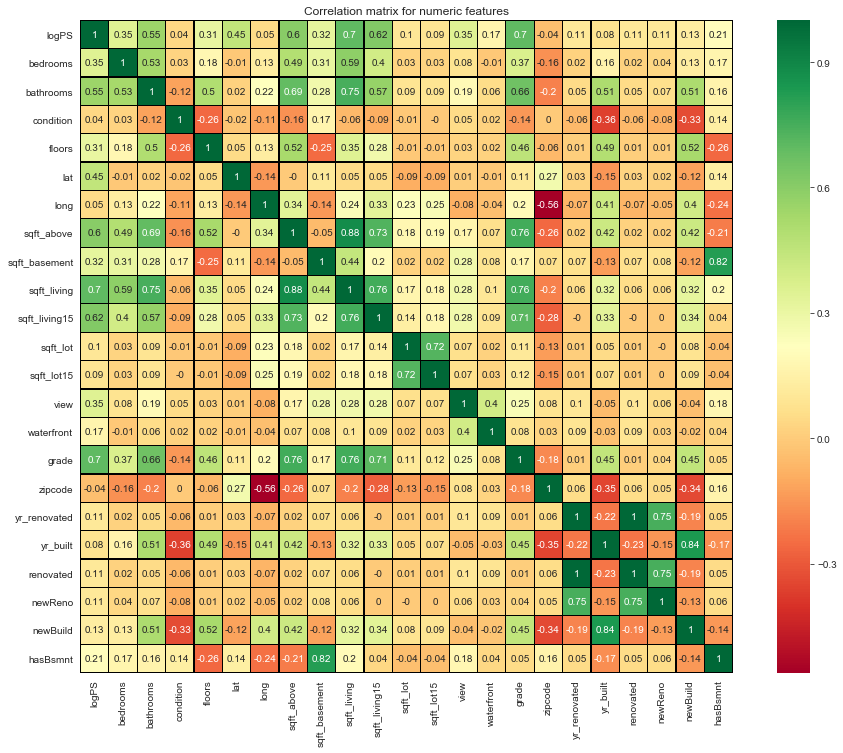

In [58]:
fig = plt.figure(figsize=(16,12)) # define plot area
ax = fig.gca()
ax.set_title('Correlation matrix for numeric features')
sns.heatmap(round(house_corr,2), ax = ax, linewidths=0.25,vmax=1.0, square=True, 
cmap="RdYlGn", linecolor='k', annot=True)

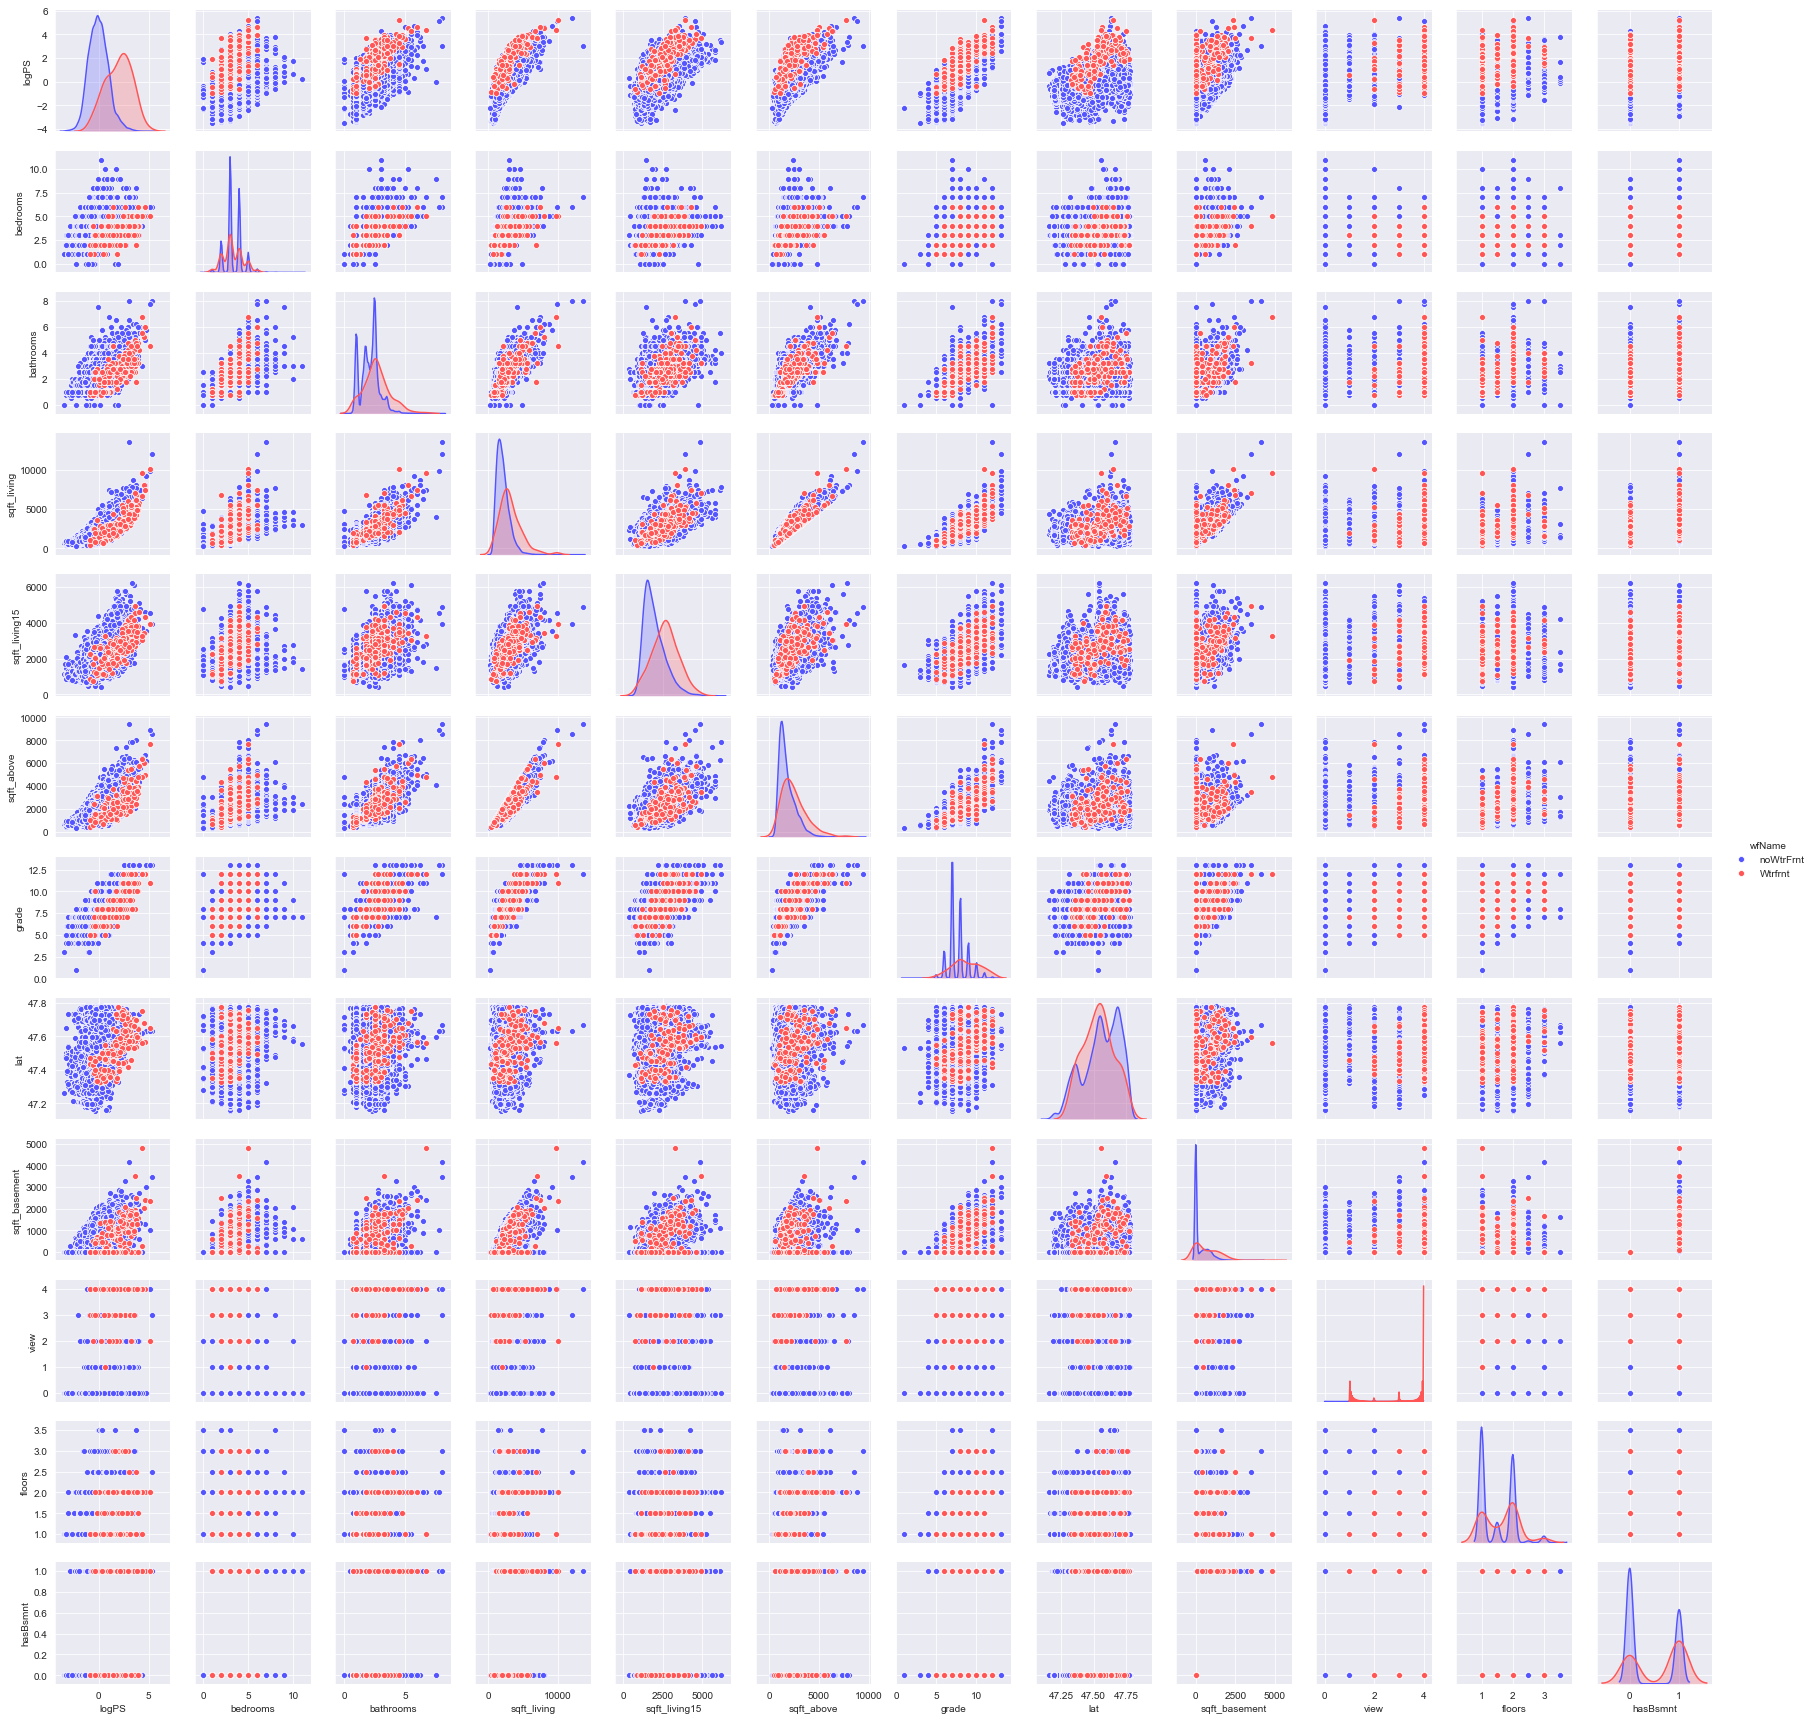

In [59]:
num_cols = ['logPS', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_living15', 'sqft_above', 'grade', 'lat', 'sqft_basement', 'view', 'floors', 'hasBsmnt', 'wfName'] 
sns.pairplot(dtrain.loc[:, num_cols], hue='wfName', 
             palette="seismic", diag_kind="kde", 
             size=2)

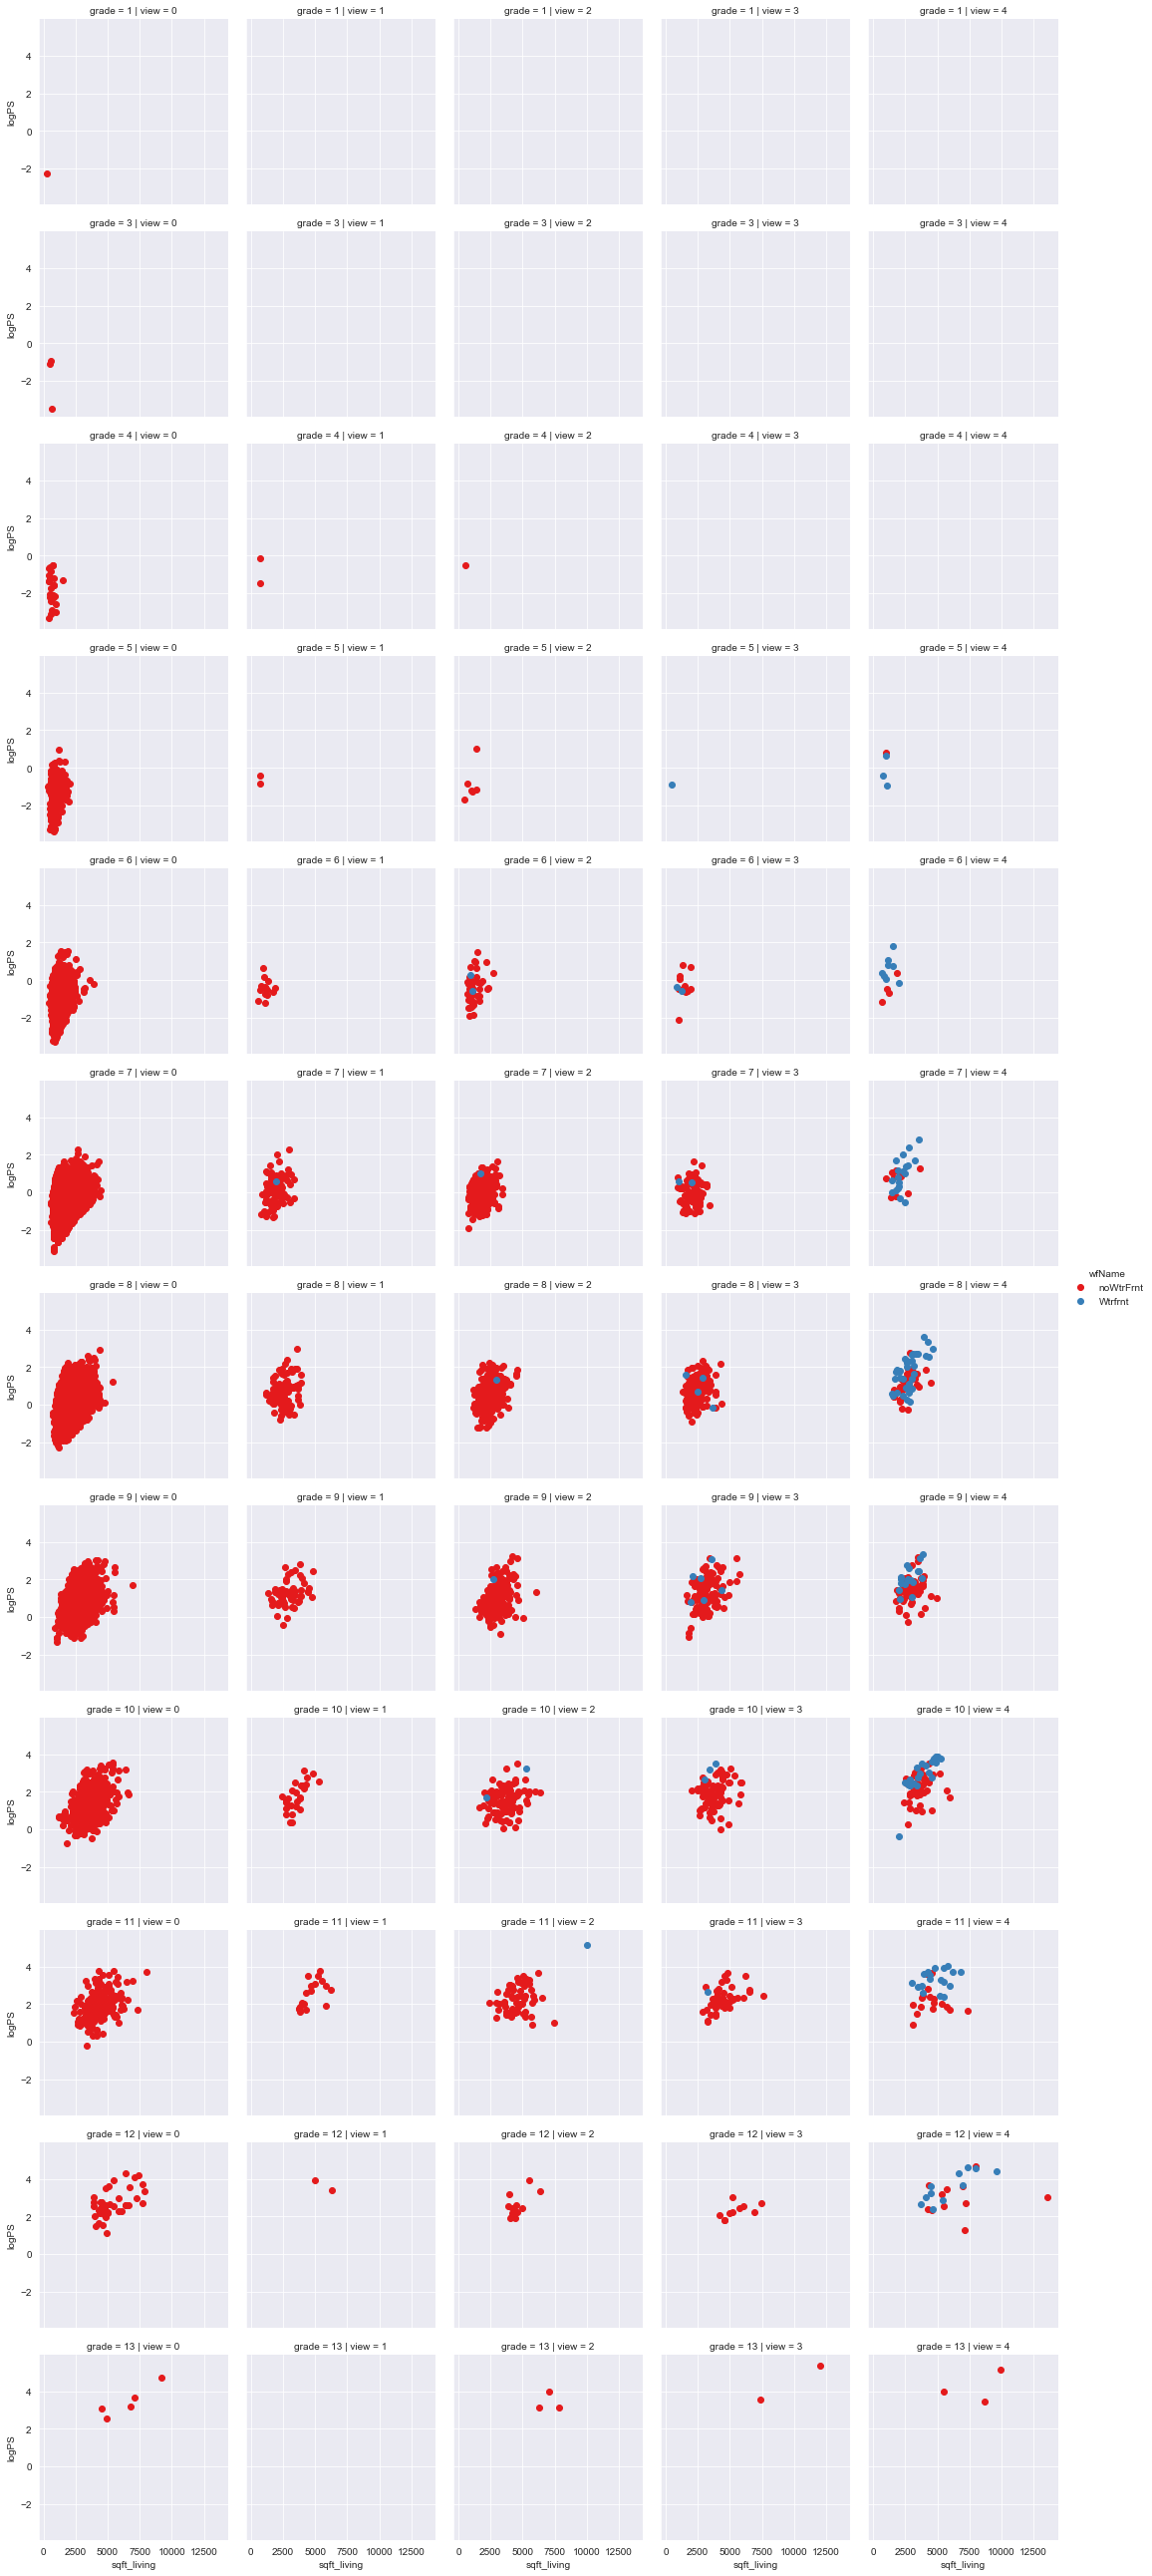

In [60]:
g = sns.FacetGrid(dtrain, 
                  col='view', 
                  row='grade',  
                  hue='wfName', 
                  palette='Set1') 
g = (g.map(plt.scatter, 'sqft_living', 'logPS').add_legend())  

In [61]:
dtrain.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,year,renovated,newReno,newBuild,hasBsmnt,wfName,log_price,priceS,logPS,viewName,condName,gradeName,view1,view2,view3,view4,cond2,cond3,cond4,cond5,grade10,grade11,grade12,grade13,grade3,grade4,grade5,grade6,grade7,grade8,grade9,zipTop,zip1,zip2,zip3,zip4
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,10,2014,0,0,0,0,noWtrFrnt,12.309982,-0.866686,-1.400889,view0,cond3,grade7,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,otherZip,0,0,0,0
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,12,2014,1,0,0,1,noWtrFrnt,13.195614,-0.005675,0.280648,view0,cond3,grade7,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,otherZip,0,0,0,0
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2,2015,0,0,0,0,noWtrFrnt,12.100712,-0.980816,-1.798227,view0,cond3,grade6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,otherZip,0,0,0,0
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,12,2014,0,0,0,1,noWtrFrnt,13.311329,0.174099,0.500356,view0,cond5,grade7,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,otherZip,0,0,0,0
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2,2015,0,0,1,0,noWtrFrnt,13.142166,-0.081943,0.179168,view0,cond3,grade8,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,otherZip,0,0,0,0


In [62]:
dtrain.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month', 'year', 'renovated', 'newReno',
       'newBuild', 'hasBsmnt', 'wfName', 'log_price', 'priceS', 'logPS',
       'viewName', 'condName', 'gradeName', 'view1', 'view2', 'view3', 'view4',
       'cond2', 'cond3', 'cond4', 'cond5', 'grade10', 'grade11', 'grade12',
       'grade13', 'grade3', 'grade4', 'grade5', 'grade6', 'grade7', 'grade8',
       'grade9', 'zipTop', 'zip1', 'zip2', 'zip3', 'zip4'],
      dtype='object')

## Modélisation prédictive

In [63]:
#Créer une nouvelle dataFrame
dfReady = dtrain.copy(deep = True)
#supprimer des colonnes
dfReady.drop(['date','price', 'priceS', 'log_price','sqft_above', 'sqft_basement', 'month', 
'year', 'view', 'condition', 'grade', 'viewName', 'condName', 'gradeName', 'yr_built', 
'yr_renovated', 'wfName', 'zipTop'],axis=1,inplace = True)
#z normalize variables
dfReady.loc[:,['bedrooms','bathrooms','sqft_living','sqft_lot','floors','zipcode','lat',
'long','sqft_living15','sqft_lot15']] = dtrain.loc[:,['bedrooms','bathrooms','sqft_living',
'sqft_lot','floors','zipcode','lat','long','sqft_living15','sqft_lot15']].apply(zscore)
#add intercept column
dfReady['intercept'] = 1
print(dfReady.shape)
dfReady.head()

(21612, 40)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,newReno,newBuild,hasBsmnt,logPS,view1,view2,view3,view4,cond2,cond3,cond4,cond5,grade10,grade11,grade12,grade13,grade3,grade4,grade5,grade6,grade7,grade8,grade9,zip1,zip2,zip3,zip4,intercept
0,-0.406924,-1.447460,-0.979841,-0.228326,-0.915466,0,1.870139,-0.352528,-0.306115,-0.943398,-0.260724,0,0,0,0,-1.400889,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,-0.406924,0.175582,0.533602,-0.189891,0.936460,0,0.879573,1.161607,-0.746375,-0.432730,-0.187877,1,0,0,1,0.280648,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,-1.508293,-1.447460,-1.426252,-0.123306,-0.915466,0,-0.933350,1.283575,-0.135692,1.070093,-0.172385,0,0,0,0,-1.798227,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,0.694446,1.149406,-0.130571,-0.244019,-0.915466,0,1.085163,-0.283244,-1.271845,-0.914217,-0.284530,0,0,0,1,0.500356,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,-0.406924,-0.149027,-0.435437,-0.169660,-0.915466,0,-0.073613,0.409591,1.199288,-0.272234,-0.192858,0,0,1,0,0.179168,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [64]:
dfReady.dtypes

bedrooms         float64
bathrooms        float64
sqft_living      float64
sqft_lot         float64
floors           float64
waterfront         int64
zipcode          float64
lat              float64
long             float64
sqft_living15    float64
sqft_lot15       float64
renovated          int64
newReno            int64
newBuild           int64
hasBsmnt           int64
logPS            float64
view1              uint8
view2              uint8
view3              uint8
view4              uint8
cond2              uint8
cond3              uint8
cond4              uint8
cond5              uint8
grade10            uint8
grade11            uint8
grade12            uint8
grade13            uint8
grade3             uint8
grade4             uint8
grade5             uint8
grade6             uint8
grade7             uint8
grade8             uint8
grade9             uint8
zip1               uint8
zip2               uint8
zip3               uint8
zip4               uint8
intercept          int64


In [65]:
from sklearn.model_selection import train_test_split
#train/test split
train, test = train_test_split(dfReady, test_size = .2) 
print(train.shape)
print(test.shape)

(17289, 40)
(4323, 40)


In [66]:
Xtest = test.loc[:, test.drop(['logPS'], axis = 1).columns]
yTest = test.loc[:, 'logPS']
Xtrain = train.loc[:, train.drop(['logPS'], axis = 1).columns]
yTrain = train.loc[:, 'logPS']

Auparavant, nous avions créé des colonnes factices pour nos 4 principaux codes postaux. Cependant, nous avons également conservé la colonne du code postal car nous ne savions pas ce qui se révélerait le plus utile pour notre modèle. Nous allons maintenant créer une liste de colonnes X, y compris le code postal, mais en supprimant les colonnes factices, et une colonne incluant les colonnes factices, mais supprimant le code postal. Nous ferons cela pour que nous ne transmettions pas les caractéristiques colinéaires à notre modèle.

In [67]:
xCatsZipOnly = list(Xtrain.drop(['zip1','zip2','zip3','zip4'], axis = 1).columns) #Drops dummy column keeps zipcode
xCatsZipTop = list(Xtrain.drop(['zipcode'], axis = 1).columns) #drops zipcode keeps dummy columns

RMSE: 19.778849697331307
                            OLS Regression Results                            
Dep. Variable:                  logPS   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     1656.
Date:                Mon, 10 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:39:28   Log-Likelihood:                -12041.
No. Observations:               17289   AIC:                         2.415e+04
Df Residuals:                   17254   BIC:                         2.442e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms         -0.0

Text(0.5,1,'Residual Histogram')

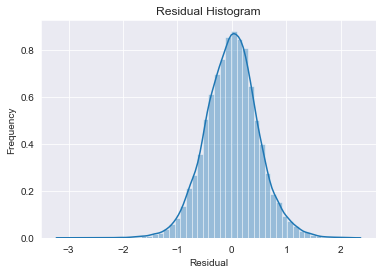

In [68]:
ols_model = sm.OLS(yTrain, Xtrain[xCatsZipOnly])

results = ols_model.fit()
n_points = Xtrain.shape[0]
y_output = yTrain

print('RMSE: {}'.format(np.sqrt(results.mse_model)))

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

In [69]:
y_pred = results.predict(Xtest[xCatsZipOnly])

In [70]:
compareOLS = pd.DataFrame({'Actual': yTest, 'Pred': y_pred})
compareOLS['resid'] = compareOLS['Actual'] - compareOLS['Pred']
compareOLS['resid2'] = compareOLS['resid'] ** 2
print('SSR: ', compareOLS.resid2.sum())

SSR = compareOLS.resid2.sum()
SST = np.sum(np.square(yTest - np.mean(yTest)))
R2 = 1.0 - (SSR / SST)
print('R-squared = {}'.format(R2))

compareOLS.head()

SSR:  983.8949780771062
R-squared = 0.7676512636427913


,Actual,Pred,resid,resid2
12242,-1.049590,-0.474669,-0.574921,0.330534
12640,0.216036,0.055377,0.160659,0.025811
5247,1.236376,0.776373,0.460004,0.211603
17371,0.141189,-0.057904,0.199093,0.039638
9338,-1.443285,-1.245150,-0.198135,0.039258


RMSE: 19.280022957407475
                            OLS Regression Results                            
Dep. Variable:                  logPS   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     1770.
Date:                Mon, 10 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:39:28   Log-Likelihood:                -11023.
No. Observations:               17289   AIC:                         2.212e+04
Df Residuals:                   17251   BIC:                         2.242e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms         -0.0

Text(0.5,1,'Residual Histogram')

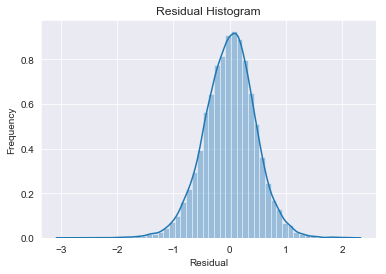

In [71]:
ols_model = sm.OLS(yTrain, Xtrain[xCatsZipTop])

results = ols_model.fit()
n_points = Xtrain.shape[0]
y_output = yTrain

print('RMSE: {}'.format(np.sqrt(results.mse_model)))

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

In [72]:
y_pred = results.predict(Xtest[xCatsZipTop])

In [73]:
compareOLS = pd.DataFrame({'Actual': yTest, 'Pred': y_pred})
compareOLS['resid'] = compareOLS['Actual'] - compareOLS['Pred']
compareOLS['resid2'] = compareOLS['resid'] ** 2
print('SSR: ', compareOLS.resid2.sum())

SSR = compareOLS.resid2.sum()
SST = np.sum(np.square(yTest - np.mean(yTest)))
R2 = 1.0 - (SSR / SST)
print('R-squared = {}'.format(R2))

compareOLS.head()

SSR:  885.1732167548985
R-squared = 0.7909646019616859


,Actual,Pred,resid,resid2
12242,-1.049590,-0.512792,-0.536798,0.288152
12640,0.216036,-0.083536,0.299573,0.089744
5247,1.236376,0.832320,0.404057,0.163262
17371,0.141189,-0.128349,0.269538,0.072651
9338,-1.443285,-1.223672,-0.219613,0.048230


In [74]:
def backward_selected(X, Y):
    # Start with all factors and intercept
    possible_factors = list(X.columns)
        
    best_aic = sm.OLS(Y, X).fit().aic
    current_aic = best_aic
    
    
    nochange = False
    #loops through all columns
    for i in range(len(X.columns)):
        #makes sure a change has been made, if no change model is done
        if nochange == False:
            nochange = True
            to_try_remove = possible_factors
            aic_candidates = []
            
            for candidate in to_try_remove:
                columns = possible_factors.copy()
                columns.remove(candidate)
                
                aic = sm.OLS(Y,X[columns]).fit().aic

                # Append tuple of the form (aic, response)
                aic_candidates.append((aic, candidate))

            # Sort all the pairs by the first entry of tuple (default of sort() method)
            aic_candidates.sort()
            #get best new AIC and feature removed
            best_new_aic, best_candidate = aic_candidates.pop(0)

            # Now check if we have something better:
            if best_new_aic < current_aic:
                # Remove the best candidate's name from possible_factors
                # set the current AIC to best AIC
                # reset no change flag
                possible_factors.remove(best_candidate)       
                current_aic = best_new_aic
                nochange = False
            
            
        # Now we repeat the process with all the remaining candidate columns

    # Here is the final formula!
    formula = "{} ~ {} + 1".format('logPS', ' + '.join(possible_factors))
    print(formula)
    # Get the model object
    model = sm.OLS(Y, X[possible_factors]).fit()
    return possible_factors, model #return best features list and model

In [75]:
#apply backwards stepwise regression
bestXCols, backwards_model = backward_selected(Xtrain[xCatsZipTop], yTrain)

print('\nAdjusted R-Squared: {}'.format(backwards_model.rsquared_adj)) 
print('AIC: {}'.format(backwards_model.aic)) 

logPS ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + waterfront + lat + long + sqft_living15 + sqft_lot15 + renovated + newReno + newBuild + hasBsmnt + view1 + view2 + view3 + view4 + cond2 + cond3 + cond4 + cond5 + grade10 + grade11 + grade12 + grade13 + grade3 + grade5 + grade6 + grade7 + grade8 + grade9 + zip1 + zip2 + zip3 + zip4 + intercept + 1

Adjusted R-Squared: 0.7910600432899516
AIC: 22120.001934779582


RMSE: 19.545960115452694
                            OLS Regression Results                            
Dep. Variable:                  logPS   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     1819.
Date:                Mon, 10 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:39:33   Log-Likelihood:                -11023.
No. Observations:               17289   AIC:                         2.212e+04
Df Residuals:                   17252   BIC:                         2.241e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms         -0.0

Text(0.5,1,'Residual Histogram')

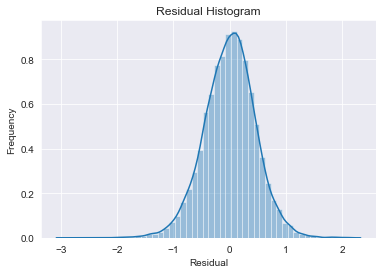

In [76]:
ols_model = sm.OLS(yTrain,Xtrain[bestXCols]) 

results = ols_model.fit() 

print('RMSE: {}'.format(np.sqrt(results.mse_model)))

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

In [77]:
y_pred = results.predict(Xtest[bestXCols]) 

In [78]:
compareOLS = pd.DataFrame({'Actual': yTest, 'Pred': y_pred}) 
compareOLS['resid'] = compareOLS['Actual'] - compareOLS['Pred'] #Find resid
compareOLS['resid2'] = compareOLS['resid'] ** 2 #Resid squared
print('SSR: ', compareOLS.resid2.sum()) #Sum SSR

SSR = compareOLS.resid2.sum()
SST = np.sum(np.square(yTest - np.mean(yTest)))
R2 = 1.0 - (SSR / SST)
print('R-squared = {}'.format(R2))

compareOLS.head()

SSR:  885.1931271477733
R-squared = 0.790959900083205


,Actual,Pred,resid,resid2
12242,-1.049590,-0.512793,-0.536797,0.288151
12640,0.216036,-0.083558,0.299594,0.089757
5247,1.236376,0.832352,0.404024,0.163235
17371,0.141189,-0.128360,0.269548,0.072656
9338,-1.443285,-1.223665,-0.219620,0.048233


In [79]:
#Checks if feature in list and removes
if 'grade3' in bestXCols:
    bestXCols.remove('grade3')
if 'renovated' in bestXCols:
    bestXCols.remove('renovated')
if 'sqft_lot15' in bestXCols:
    bestXCols.remove('sqft_lot15')
if 'grade8' in bestXCols:
    bestXCols.remove('grade8')

RMSE: 20.709406257717056
                            OLS Regression Results                            
Dep. Variable:                  logPS   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     2026.
Date:                Mon, 10 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:39:35   Log-Likelihood:                -11093.
No. Observations:               17289   AIC:                         2.225e+04
Df Residuals:                   17256   BIC:                         2.251e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms         -0.0

Text(0.5,1,'Residual Histogram')

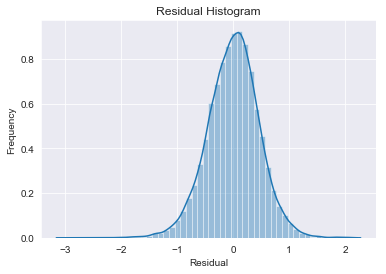

In [80]:
ols_model = sm.OLS(yTrain,Xtrain[bestXCols]) 

results = ols_model.fit() 

print('RMSE: {}'.format(np.sqrt(results.mse_model)))

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

In [81]:
y_pred = results.predict(Xtest[bestXCols]) 

In [82]:
#Xtrain[bestXCols].shape

In [83]:
compareOLS = pd.DataFrame({'Actual': yTest, 'Pred': y_pred}) 
compareOLS['resid'] = compareOLS['Actual'] - compareOLS['Pred'] #Create resid
compareOLS['resid2'] = compareOLS['resid'] ** 2 #create resid squared
print('SSR: ', compareOLS.resid2.sum()) #sum of square resids

SSR = compareOLS.resid2.sum()
SST = np.sum(np.square(yTest - np.mean(yTest)))
R2 = 1.0 - (SSR / SST)
print('R-squared = {}'.format(R2))

compareOLS.head()

SSR:  886.3900279893113
R-squared = 0.7906772495927841


,Actual,Pred,resid,resid2
12242,-1.049590,-0.521701,-0.527889,0.278667
12640,0.216036,-0.085936,0.301973,0.091188
5247,1.236376,0.840424,0.395952,0.156778
17371,0.141189,-0.125533,0.266722,0.071141
9338,-1.443285,-1.225366,-0.217919,0.047489


### Gradient boosting

In [84]:
#object for the gradient boosting
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(yTrain, Xtrain[bestXCols])

C:\Users\Fitec\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [85]:
print(gb)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=       bedrooms  bathrooms  sqft_living  sqft_lot    floors  waterfront  \
7320   0.694446  -0.149027     0.653371 -0.022945 -0.915466           0
4759   1.795815   0.500190     1.197775 -0.031419  0.936460           0
9229   1.795815   0.500190     0.490050 -0.157975  0.936460  ...9049     0          1
10131     0          1
12725     0          1

[17289 rows x 33 columns],
             loss=7320     0.234206
4759     1.036012
9229     1.204103
9521     0.534624
3276    -0.031249
20432    0.234206
10484   -0.258525
2910     0.179168
12339   -0.212213
12775   -1.906752
1439    -0.020879
14830    0.003780
14024   -0.735692
1743     0.171707
20584    0.331144
2362    -0.972936
8209   ...180
19049    1.059887
10131   -0.772206
12725   -0.590683
Name: logPS, Length: 17289, dtype: float64,
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0

In [87]:
#training process
gb.fit([yTrain], Xtrain[bestXCols])

ValueError: bad input shape (17289, 33)

In [ ]:
#prediction
y_pred = gb.predict(Xtest)

In [ ]:
#evaluation : test error rate
from sklearn import metrics
err = 1.0 - metrics.accuracy_score(ytest,y_pred)
print(err)

In [ ]:
#research grid for settings
from sklearn.grid_search import GridSearchCV

In [ ]:
#parameters to try
parametres = {"learning_rate":[0.3,0.2,0.1,0.05,0.01],"max_depth":[2,3,4,5,6],"subsample":[1.0,0.8,0.5],"max_features":[None,'sqrt','log2']}

In [ ]:
#learning classifier to use
gbc = GradientBoostingClassifier()

In [ ]:
#object for the search
cfl = GridSearchCV(estimator=gbc,param_grid=parametres,scoring="accuracy")

#search process
resultats = cfl.fit(X_app,y_app)

#all performances
print(resultats.grid_scores_)

#best performances
print(resultats.best_score_)

In [ ]:
#best parameters
print(resultats.best_params_)

#prediction with the best parameters
ypredc = resultats.predict(Xtest)

#test error rate
err_best = 1.0 - metrics.accuracy_score(ytest,ypredc)
print(err_best)

In [ ]:
#random forest
from sklearn.ensemble import RandomForestClassifier

#object RandomForest
rf = RandomForestClassifier(n_estimators = 100)

#learning process
rf.fit(X_app,y_app)

#prediction
y_pred_rf = rf.predict(Xtest)

#test error rate
err = 1.0 - metrics.accuracy_score(ytest,y_pred_rf)
print(err)